# Calibration of a line to data comparing approaches to dealing with systematic error

In [1]:
import rxmc

Using database version X4-2024-12-31 located in: /home/kyle/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [2]:
from collections import OrderedDict

import corner
import matplotlib.patches as mpatches
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

## Plotting functions

In [3]:
def plot_chains(walker, model, true_params):
    fig, axes = plt.subplots(
        walker.model_chain.shape[1] + 1, 1, figsize=(8, 8), sharex=True
    )
    for i in range(walker.model_chain.shape[1]):
        axes[i].plot(walker.model_chain[:, i])
        axes[i].set_ylabel(f"${model.params[i].latex_name}$ [{model.params[i].unit}]")
        true_value = true_params[model.params[i].name]
        axes[i].hlines(true_value, 0, len(walker.model_chain), "r", linestyle="--")

    axes[-1].plot(walker.log_posterior_record)
    axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

    axes[-1].set_xlabel(r"$i$")
    # plt.legend(title="chains", ncol=3,)

In [4]:
def plot_posterior_corner(walker, true_params):
    fig = corner.corner(
        walker.model_chain,
        labels=[p.name for p in my_model.params],
        label="posterior",
        truths=[true_params["m"], true_params["b"]],
    )
    fig.suptitle("posterior")

In [5]:
def plot_predictive_post(walker, model, x, y_exp, y_err, y_true, x_true=None):
    if x_true is None:
        x_true = x
    n_posterior_samples = walker.model_chain.shape[0]
    y = np.zeros((n_posterior_samples, len(x)))
    for i in range(n_posterior_samples):
        sample = walker.model_chain[i, :]
        y[i, :] = model.y(x, *sample)

    upper, median, lower = np.percentile(y, [5, 50, 95], axis=0)
    plt.errorbar(
        x,
        y_exp,
        y_err,
        color="k",
        marker="o",
        linestyle="none",
        label="experiment",
    )

    plt.plot(x, y_true, "k--", label="truth")
    plt.plot(x, median, "m:", label="posterior median")
    plt.fill_between(
        x,
        lower,
        upper,
        alpha=0.5,
        zorder=2,
        label=r"posterior inner 90$^\text{th}$ pctl",
    )
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")

## make the model

In [6]:
class LinearModel(rxmc.physical_model.PhysicalModel):
    def __init__(self):
        params = [
            rxmc.params.Parameter("m", float, "no-units"),
            rxmc.params.Parameter("b", float, "y-units"),
        ]
        super().__init__(params)

    def y(self, x, m, b):
        return m * x + b

    def evaluate(self, observation, m, b):
        return self.y(observation.x, m, b)

In [7]:
my_model = LinearModel()

In [8]:
rng = np.random.default_rng(13)

## set up prior

In [9]:
true_params = OrderedDict(
    [
        ("m", 0.6),
        ("b", 2),
    ]
)

In [10]:
prior_mean = OrderedDict(
    [
        ("m", 2),
        ("b", 5),
    ]
)
prior_std_dev = OrderedDict(
    [
        ("m", 2),
        ("b", 2),
    ]
)

In [11]:
covariance = np.diag(list(prior_std_dev.values())) ** 2
mean = np.array(list(prior_mean.values()))
prior_distribution = stats.multivariate_normal(mean, covariance)

In [12]:
systematic_fractional_err = 0.1
# choose a normalization 1 std deviation below the mean
N = 1 - systematic_fractional_err
noise_fraction = 0.05
x = np.linspace(0.01, 1.0, 15, dtype=float)
y_true = my_model.y(x, *list(true_params.values()))
y_exp = (y_true + rng.normal(scale=noise_fraction * y_true, size=len(x))) * N
y_stat_err = noise_fraction * y_exp * N

Text(0.5, 1.0, 'experimental constraint with bias')

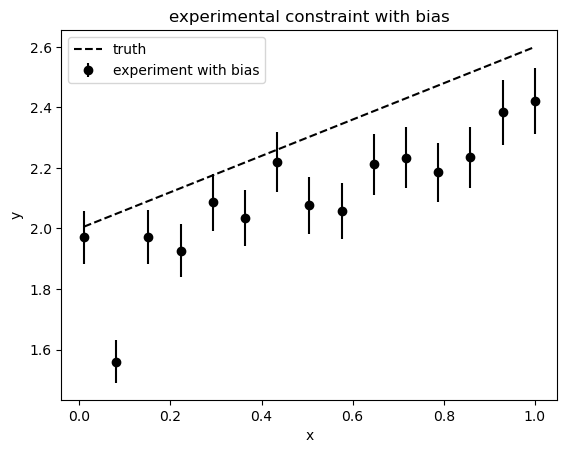

In [13]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment with bias",
)
plt.plot(x, y_true, "k--", label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("experimental constraint with bias")

## Compare Likelihood Models
We will look at a few different cases:
1. Covariance is fixed to just statistical error (disregarding systematic error)

   \begin{equation}
       \Sigma_{ij} = \delta_{ij} \sigma_{stat,i}^2
   \end{equation}

3. Covariance is just statistical error, but we fit the magnitude of the statistical noise $\eta$ (disregarding systematic error). This means the covariance is not fixed, but will be updated during calibration.

   \begin{equation}
       \Sigma_{ij} = \delta_{ij} \eta^2 y_m(x_j; \alpha)^2
   \end{equation}


5. Systematic error is included properly in covariance, making the covariance a function of the model prediction. Again, this means the covariance is not fixed, but will be updated during calibration.

    \begin{equation}
       \Sigma_{ij}(\alpha) = \delta_{ij} \sigma_{stat,i}^2 + \sigma_N^2 y_m(x_i; \alpha) y_m(x_j; \alpha)
   \end{equation}

7. Systematic error is included improperly in covariance, using the experimental $y(x_i)$ instead of the model prediction $y_m(x_i;\alpha)$. In this case the covariance is again fixed.

    \begin{equation}
       \Sigma_{ij} = \delta_{ij} \sigma_{stat,i}^2 + \sigma_N^2 y(x_i) y(x_j)
   \end{equation}


In [14]:
# 1 and 2
obs_stat_only = rxmc.observation.Observation(
    x=x,
    y=y_exp,
    y_stat_err=y_stat_err,
)

# 3
obs_sys_norm_correct = rxmc.observation.Observation(
    x=x,
    y=y_exp,
    y_stat_err=y_stat_err,
    y_sys_err_normalization=systematic_fractional_err,
)

# 4
obs_sys_norm_wrong = rxmc.observation.FixedCovarianceObservation(
    x=x,
    y=y_exp,
    covariance=np.diag(y_stat_err**2)
    + systematic_fractional_err**2 * np.outer(y_exp, y_exp),
)

## set up likelihood models and constraints

In [15]:
# 1 and 3
likelihood = rxmc.likelihood_model.LikelihoodModel()

# 4
likelihood_fixed_cov = rxmc.likelihood_model.FixedCovarianceLikelihood()


# 2 - a special likelihood model that takes in the noise fraction as a parameter
likelihood_unknown_stat = rxmc.likelihood_model.UnknownNoiseFractionErrorModel()

In [16]:
# 1
evidence_stat_only = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [obs_stat_only],
            my_model,
            likelihood,
        )
    ]
)

# 2
evidence_unknown_stat = rxmc.evidence.Evidence(
    constraints=[],
    parametric_constraints=[
        rxmc.constraint.Constraint(
            [obs_stat_only],
            my_model,
            likelihood_unknown_stat,
        )
    ],
)

# 3
evidence_sys_correct = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [obs_sys_norm_correct],
            my_model,
            likelihood,
        )
    ]
)

# 4
evidence_sys_wrong = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [obs_sys_norm_wrong],
            my_model,
            likelihood_fixed_cov,
        )
    ]
)

In [17]:
def proposal_distribution_model(x):
    return stats.multivariate_normal.rvs(
        mean=x, cov=prior_distribution.cov / 1000, random_state=rng
    )

In [18]:
my_model_sampling_config = rxmc.param_sampling.SamplingConfig(
    params=my_model.params,
    starting_location=prior_distribution.mean,
    proposal=proposal_distribution_model,
    prior=prior_distribution,
)

## Run option 1: fixed covariance, statistical error only

In [19]:
walker1 = rxmc.walker.Walker(
    my_model_sampling_config,
    evidence_stat_only,
    rng=rng,
)

In [20]:
%%time
walker1.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.328
CPU times: user 5.24 s, sys: 315 ms, total: 5.55 s
Wall time: 5.23 s


0.3282

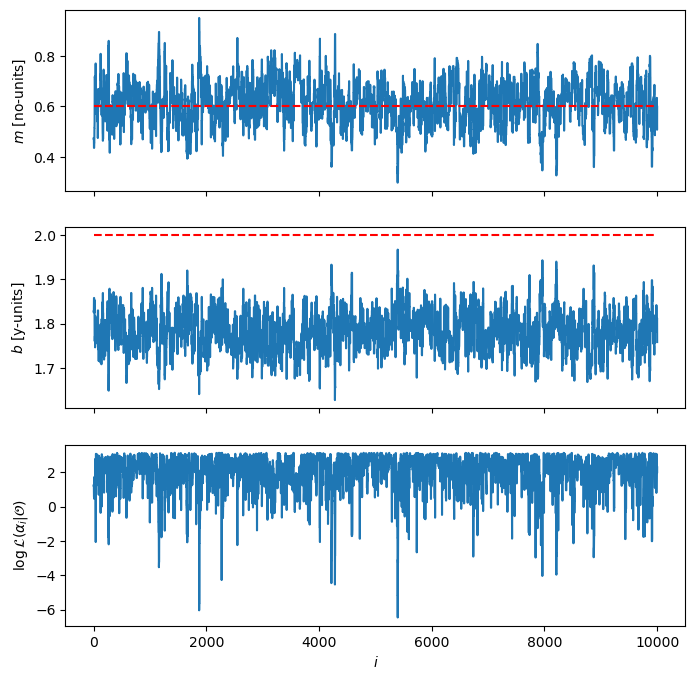

In [21]:
plot_chains(walker=walker1, model=my_model, true_params=true_params)

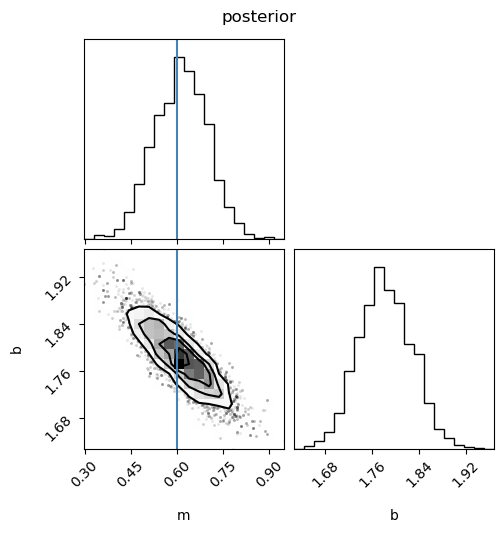

In [22]:
plot_posterior_corner(walker=walker1, true_params=true_params)

Text(0.5, 1.0, 'option 1: fixed statistical error, systematic ignored')

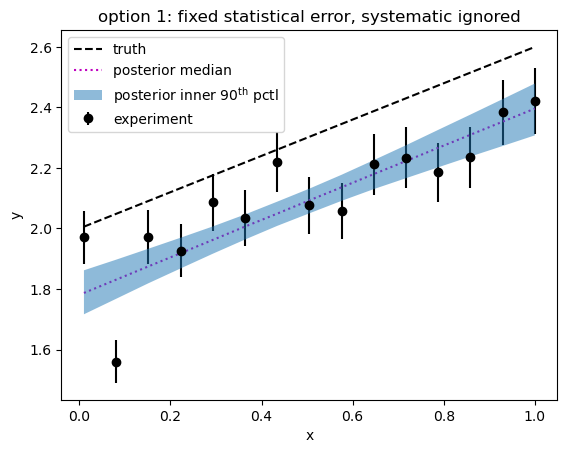

In [23]:
plot_predictive_post(
    walker=walker1, model=my_model, x=x, y_exp=y_exp, y_err=y_stat_err, y_true=y_true
)
plt.title("option 1: fixed statistical error, systematic ignored")

## Run option 2: unknown statistical error

We need to come up with a prior for the noise for option 2. We will keep it fairly wide and centered about the reported value.

In [24]:
noise_prior = stats.norm(loc=noise_fraction, scale=0.1)

In [25]:
def proposal_distribution_noise(x):
    return np.atleast_1d(
        np.fabs(
            stats.multivariate_normal.rvs(
                mean=x, cov=np.array([[0.005]]), random_state=rng
            )
        )
    )

In [26]:
noise_sampling_config = rxmc.param_sampling.SamplingConfig(
    params=likelihood_unknown_stat.params,
    starting_location=noise_prior.mean(),
    proposal=proposal_distribution_noise,
    prior=noise_prior,
)

In [27]:
def proposal_distribution_model_unknown_stat(x):
    return stats.multivariate_normal.rvs(
        mean=x, cov=prior_distribution.cov / 10, random_state=rng
    )

In [28]:
model_sampling_config2 = rxmc.param_sampling.SamplingConfig(
    params=my_model.params,
    starting_location=prior_distribution.mean,
    proposal=proposal_distribution_model_unknown_stat,
    prior=prior_distribution,
)

In [29]:
walker2 = rxmc.walker.Walker(
    model_sample_conf=my_model_sampling_config,
    evidence=evidence_unknown_stat,
    likelihood_sample_confs=[noise_sampling_config],
    rng=rng,
)

In [30]:
%%time
walker2.walk(
    n_steps=10000,
    burnin=1000,
    batch_size=100,
)

Burn-in batch 1/10 completed, 100 steps.
Burn-in batch 2/10 completed, 100 steps.
Burn-in batch 3/10 completed, 100 steps.
Burn-in batch 4/10 completed, 100 steps.
Burn-in batch 5/10 completed, 100 steps.
Burn-in batch 6/10 completed, 100 steps.
Burn-in batch 7/10 completed, 100 steps.
Burn-in batch 8/10 completed, 100 steps.
Burn-in batch 9/10 completed, 100 steps.
Burn-in batch 10/10 completed, 100 steps.
Batch: 1/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.440
  Likelihood parameter acceptance fractions: [0.23]
Batch: 2/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.520
  Likelihood parameter acceptance fractions: [0.31]
Batch: 3/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.590
  Likelihood parameter acceptance fractions: [0.27]
Batch: 4/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.460
  Likelihood parameter acceptance fractions: [0.28]
Batch: 5/100 completed, 100 steps. 
  Model parameter acc

(0.4627, [0.2533])

In [31]:
def plot_chains_with_err(walker, model, true_params):
    fig, axes = plt.subplots(
        walker.model_chain.shape[1] + 3, 1, figsize=(8, 8), sharex=True
    )
    for i in range(walker.model_chain.shape[1]):
        axes[i].plot(walker.model_chain[:, i])
        axes[i].set_ylabel(f"${model.params[i].latex_name}$ [{model.params[i].unit}]")
        true_value = true_params[model.params[i].name]
        axes[i].hlines(true_value, 0, len(walker.model_chain), "r", linestyle="--")

    axes[-3].plot(walker.log_posterior_record)
    axes[-3].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

    lmp = walker.likelihood_sample_confs[0].params[0]
    axes[-2].plot(walker.likelihood_chain[0])
    axes[-2].set_ylabel(f"${lmp.latex_name}$ [{lmp.unit}]")
    axes[-2].hlines(noise_fraction, 0, len(walker.model_chain), "r", linestyle="--")

    axes[-1].plot(walker.log_posterior_record_lm[0])
    axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

    axes[-1].set_xlabel(r"$i$")
    # plt.legend(title="chains", ncol=3,)

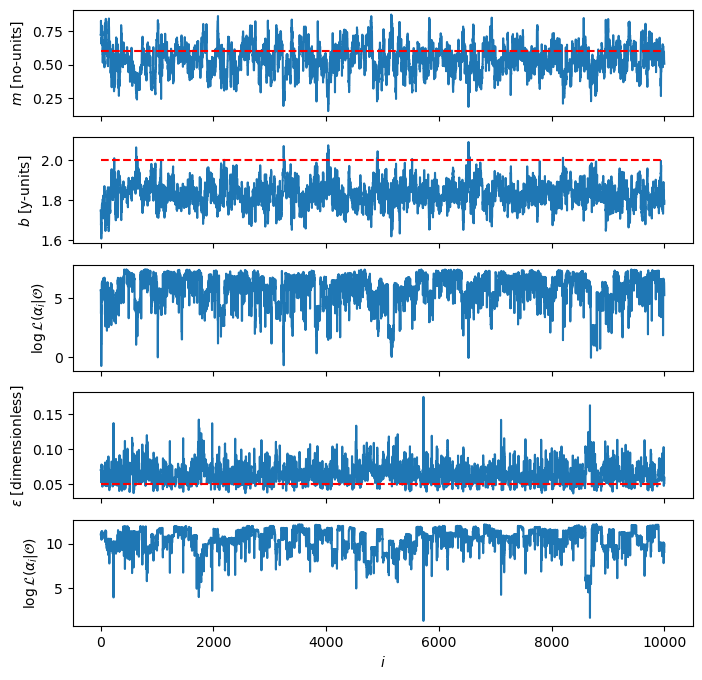

In [32]:
plot_chains_with_err(walker2, my_model, true_params)

Text(0.5, 0.98, 'posterior')

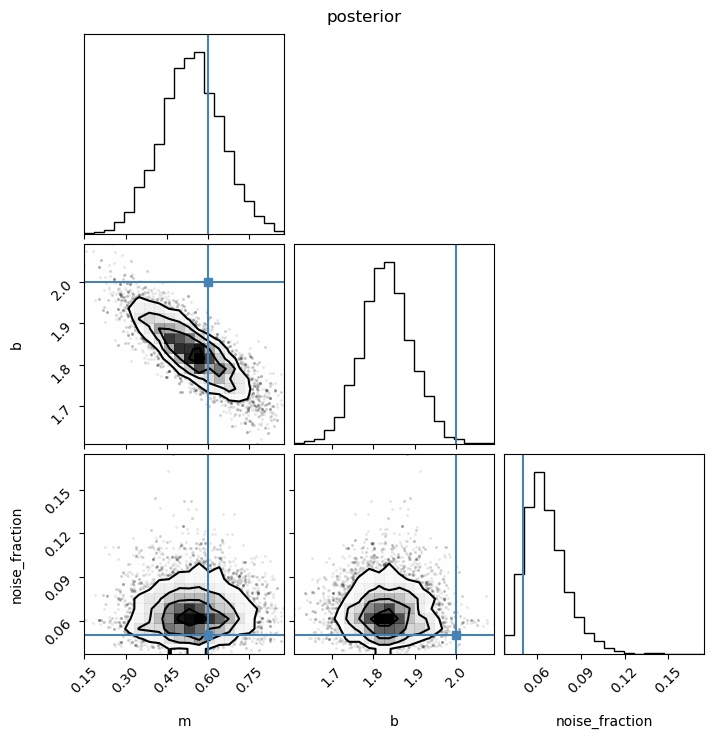

In [33]:
fig = corner.corner(
    np.hstack([walker2.model_chain, walker2.likelihood_chain[0]]),
    labels=[p.name for p in my_model.params]
    + [walker2.likelihood_sample_confs[0].params[0].name],
    label="posterior",
    truths=[true_params["m"], true_params["b"], noise_fraction],
)
fig.suptitle("posterior")

Text(0.5, 1.0, 'option 2: unknown statistical error, systematic ignored')

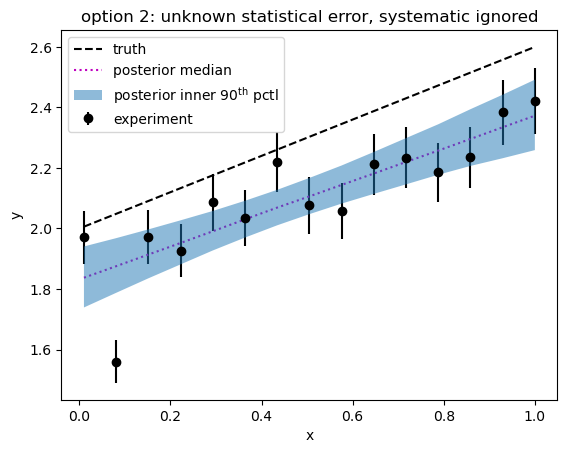

In [34]:
plot_predictive_post(
    walker=walker2, model=my_model, x=x, y_exp=y_exp, y_err=y_stat_err, y_true=y_true
)
plt.title("option 2: unknown statistical error, systematic ignored")

## Run option 3: correct formulation of the systematic error

In [35]:
walker3 = rxmc.walker.Walker(
    my_model_sampling_config,
    evidence_sys_correct,
    rng=rng,
)

In [36]:
%%time
walker3.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.738
CPU times: user 5.87 s, sys: 20.4 ms, total: 5.89 s
Wall time: 6.11 s


0.7379

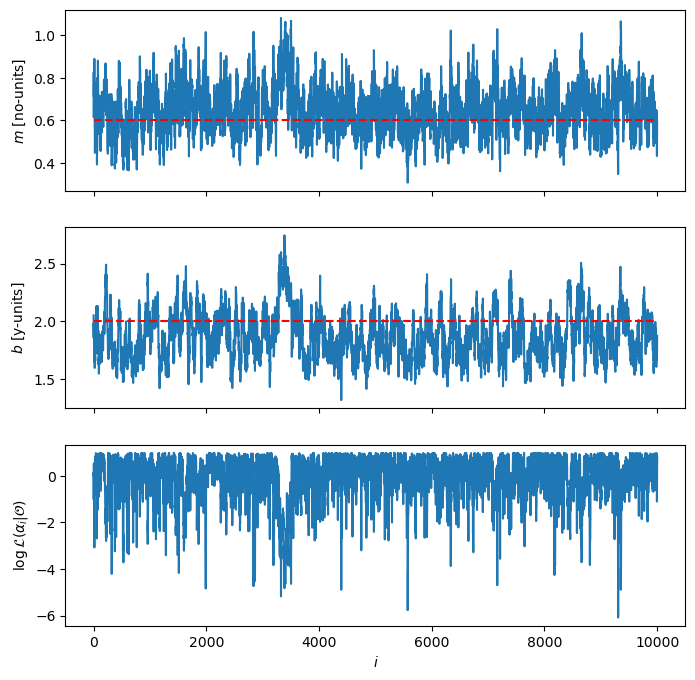

In [37]:
plot_chains(walker=walker3, model=my_model, true_params=true_params)

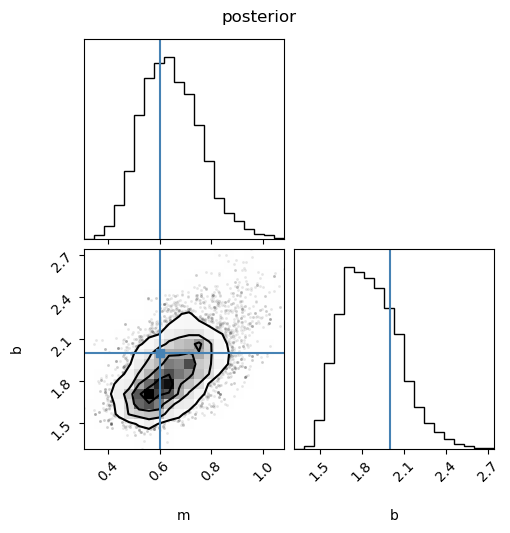

In [38]:
plot_posterior_corner(walker=walker3, true_params=true_params)

Text(0.5, 1.0, 'option 3: systematic included correctly')

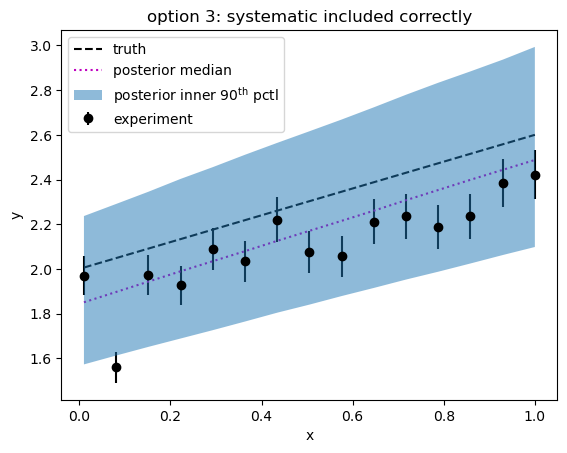

In [39]:
plot_predictive_post(
    walker=walker3, model=my_model, x=x, y_exp=y_exp, y_err=y_stat_err, y_true=y_true
)
plt.title("option 3: systematic included correctly")

## Run option 4: incorrect formulation of the systematic error

In [40]:
walker4 = rxmc.walker.Walker(
    my_model_sampling_config,
    evidence_sys_wrong,
    rng=rng,
)

In [41]:
%%time
walker4.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.722
CPU times: user 4.42 s, sys: 17.5 ms, total: 4.44 s
Wall time: 4.58 s


0.7224

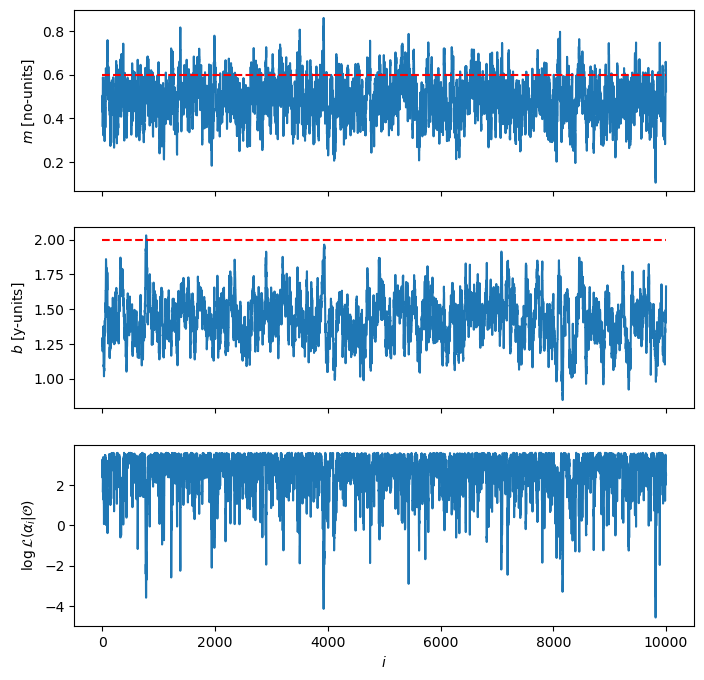

In [42]:
plot_chains(walker=walker4, model=my_model, true_params=true_params)

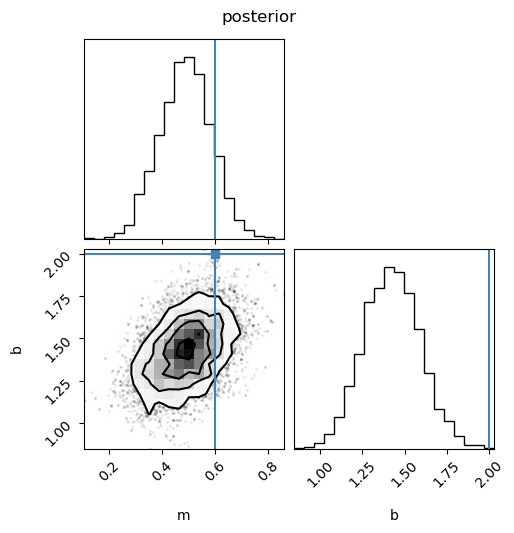

In [43]:
plot_posterior_corner(walker=walker4, true_params=true_params)

Text(0.5, 1.0, 'option 4: systematic included incorrectly')

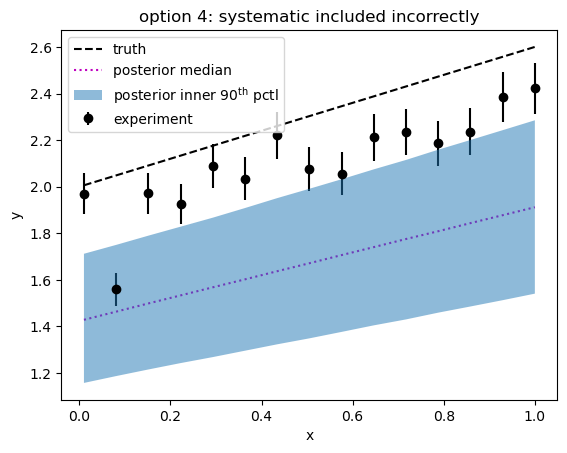

In [44]:
plot_predictive_post(
    walker=walker4, model=my_model, x=x, y_exp=y_exp, y_err=y_stat_err, y_true=y_true
)
plt.title("option 4: systematic included incorrectly")

# Multiple constraints
Let's choose a second constraint, with the same normalization bias in the opposite direction and the same coverage over the $x$-domain.

In [45]:
systematic_fractional_err2 = 0.1
# choose a normalization 1 std deviation above the mean this time
N2 = 1 + systematic_fractional_err2
noise_fraction2 = 0.025
x2 = np.linspace(0.01, 0.8, 27, dtype=float)
y_true2 = my_model.y(x2, *list(true_params.values()))
y_exp2 = (y_true2 + rng.normal(scale=noise_fraction2 * y_true2, size=len(x2))) * N2
y_stat_err2 = noise_fraction2 * y_exp2 * N2

In [46]:
x_full = np.linspace(-1, 2, 100)
y_true_full = my_model.y(x_full, *list(true_params.values()))

Text(0.5, 1.0, 'multiple experimental constraint with opposite bias')

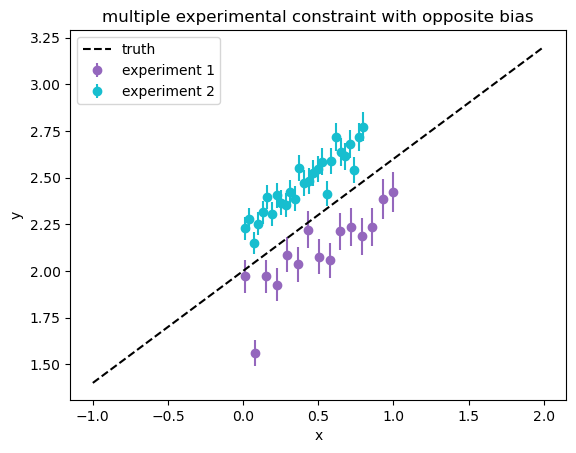

In [47]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    marker="o",
    linestyle="none",
    label="experiment 1",
    color="tab:purple",
)
plt.errorbar(
    x2,
    y_exp2,
    y_stat_err2,
    marker="o",
    linestyle="none",
    label="experiment 2",
    color="tab:cyan",
)

plt.plot(x_full, y_true_full, "k--", label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("multiple experimental constraint with opposite bias")

In [48]:
# 1 and 2
obs_stat_only2 = rxmc.observation.Observation(
    x=x2,
    y=y_exp2,
    y_stat_err=y_stat_err2,
)

# 3
obs_sys_norm_correct2 = rxmc.observation.Observation(
    x=x2,
    y=y_exp2,
    y_stat_err=y_stat_err2,
    y_sys_err_normalization=systematic_fractional_err2,
)

# 4
obs_sys_norm_wrong2 = rxmc.observation.FixedCovarianceObservation(
    x=x2,
    y=y_exp2,
    covariance=np.diag(y_stat_err2**2)
    + systematic_fractional_err2**2 * np.outer(y_exp2, y_exp2),
)

## set up likelihood models and constraints

In [49]:
# 1
evidence_stat_only = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [obs_stat_only, obs_stat_only2],
            my_model,
            likelihood,
        )
    ]
)

# 2
evidence_unknown_stat = rxmc.evidence.Evidence(
    constraints=[],
    parametric_constraints=[
        rxmc.constraint.Constraint(
            [obs_stat_only, obs_stat_only2],
            my_model,
            likelihood_unknown_stat,
        )
    ],
)

# 3
evidence_sys_correct = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [obs_sys_norm_correct, obs_sys_norm_correct2],
            my_model,
            likelihood,
        )
    ]
)

# 4
evidence_sys_wrong = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [obs_sys_norm_wrong, obs_sys_norm_wrong2],
            my_model,
            likelihood_fixed_cov,
        )
    ]
)

In [50]:
walker1 = rxmc.walker.Walker(
    my_model_sampling_config,
    evidence_stat_only,
    rng=rng,
)

In [51]:
%%time
walker1.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.153
CPU times: user 7.14 s, sys: 418 ms, total: 7.55 s
Wall time: 7.33 s


0.1528

In [52]:
upper1, med1, lower1 = np.percentile(
    [my_model.y(x_full, *p) for p in walker1.model_chain],
    [5, 50, 95],
    axis=0,
)

In [53]:
walker2 = rxmc.walker.Walker(
    model_sample_conf=my_model_sampling_config,
    evidence=evidence_unknown_stat,
    likelihood_sample_confs=[noise_sampling_config],
    rng=rng,
)

In [54]:
%%time
walker2.walk(
    n_steps=10000,
    burnin=1000,
    batch_size=100,
)

Burn-in batch 1/10 completed, 100 steps.
Burn-in batch 2/10 completed, 100 steps.
Burn-in batch 3/10 completed, 100 steps.
Burn-in batch 4/10 completed, 100 steps.
Burn-in batch 5/10 completed, 100 steps.
Burn-in batch 6/10 completed, 100 steps.
Burn-in batch 7/10 completed, 100 steps.
Burn-in batch 8/10 completed, 100 steps.
Burn-in batch 9/10 completed, 100 steps.
Burn-in batch 10/10 completed, 100 steps.
Batch: 1/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.420
  Likelihood parameter acceptance fractions: [0.21]
Batch: 2/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.530
  Likelihood parameter acceptance fractions: [0.23]
Batch: 3/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.490
  Likelihood parameter acceptance fractions: [0.23]
Batch: 4/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.380
  Likelihood parameter acceptance fractions: [0.23]
Batch: 5/100 completed, 100 steps. 
  Model parameter acc

(0.4725, [0.1872])

In [55]:
upper2, med2, lower2 = np.percentile(
    [my_model.y(x_full, *p) for p in walker2.model_chain],
    [5, 50, 95],
    axis=0,
)

In [56]:
walker3 = rxmc.walker.Walker(
    my_model_sampling_config,
    evidence_sys_correct,
    rng=rng,
)

In [57]:
%%time
walker3.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.590
CPU times: user 7.27 s, sys: 7.38 ms, total: 7.28 s
Wall time: 7.43 s


0.59

In [58]:
upper3, med3, lower3 = np.percentile(
    [my_model.y(x_full, *p) for p in walker3.model_chain],
    [5, 50, 95],
    axis=0,
)

In [59]:
walker4 = rxmc.walker.Walker(
    my_model_sampling_config,
    evidence_sys_wrong,
    rng=rng,
)

In [60]:
%%time
walker4.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.592
CPU times: user 4.6 s, sys: 19.6 ms, total: 4.62 s
Wall time: 4.74 s


0.5922

In [61]:
upper4, med4, lower4 = np.percentile(
    [my_model.y(x_full, *p) for p in walker4.model_chain],
    [5, 50, 95],
    axis=0,
)

Text(0.5, 1.0, 'multiple constraints with systematic normalization error')

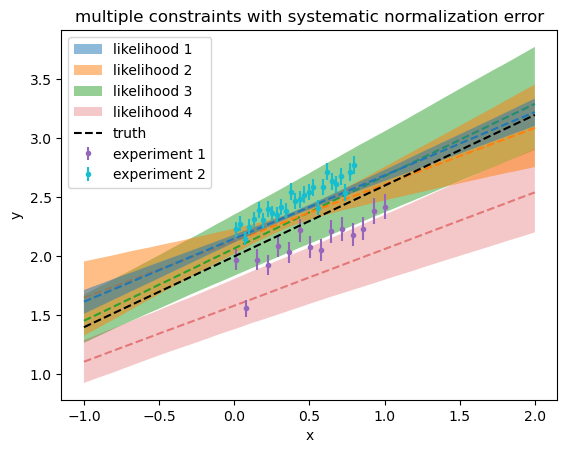

In [62]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    marker=".",
    linestyle="none",
    label="experiment 1",
    color="tab:purple",
    zorder=999,
)
plt.errorbar(
    x2,
    y_exp2,
    y_stat_err2,
    marker=".",
    linestyle="none",
    label="experiment 2",
    color="tab:cyan",
    zorder=999,
)
p = plt.fill_between(x_full, lower1, upper1, label="likelihood 1", alpha=0.5, zorder=99)
plt.plot(x_full, med1, "--", color=p.get_facecolor(), alpha=1, zorder=100)


p = plt.fill_between(x_full, lower2, upper2, label="likelihood 2", alpha=0.5, zorder=89)
plt.plot(x_full, med2, "--", color=p.get_facecolor(), alpha=1, zorder=90)


p = plt.fill_between(x_full, lower3, upper3, label="likelihood 3", alpha=0.5)
plt.plot(x_full, med3, "--", color=p.get_facecolor(), alpha=1, zorder=89)

p = plt.fill_between(x_full, lower4, upper4, label="likelihood 4", alpha=0.25)
plt.plot(x_full, med4, "--", color=p.get_facecolor(), alpha=0.5)


plt.plot(x_full, y_true_full, "k--", label="truth", zorder=999)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("multiple constraints with systematic normalization error")

# Multiple constraints with offset domain
Let's choose a second constraint, with the same normalization bias in the opposite direction and slightly different coverage opver $x$."

In [63]:
x2 = np.linspace(0.6, 1.4, 27, dtype=float)
y_true2 = my_model.y(x2, *list(true_params.values()))
y_exp2 = (y_true2 + rng.normal(scale=noise_fraction2 * y_true2, size=len(x2))) * N2
y_stat_err2 = noise_fraction2 * y_exp2 * N2

Text(0.5, 1.0, '$x$-offset experimental constraint with opposite bias')

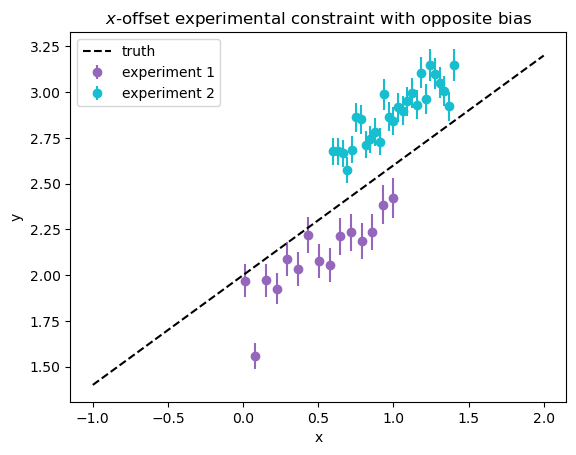

In [64]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    marker="o",
    linestyle="none",
    label="experiment 1",
    color="tab:purple",
)
plt.errorbar(
    x2,
    y_exp2,
    y_stat_err2,
    marker="o",
    linestyle="none",
    label="experiment 2",
    color="tab:cyan",
)

plt.plot(x_full, y_true_full, "k--", label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("$x$-offset experimental constraint with opposite bias")

In [65]:
# 1 and 2
obs_stat_only2 = rxmc.observation.Observation(
    x=x2,
    y=y_exp2,
    y_stat_err=y_stat_err2,
)

# 3
obs_sys_norm_correct2 = rxmc.observation.Observation(
    x=x2,
    y=y_exp2,
    y_stat_err=y_stat_err2,
    y_sys_err_normalization=systematic_fractional_err2,
)

# 4
obs_sys_norm_wrong2 = rxmc.observation.FixedCovarianceObservation(
    x=x2,
    y=y_exp2,
    covariance=np.diag(y_stat_err2**2)
    + systematic_fractional_err2**2 * np.outer(y_exp2, y_exp2),
)

## set up likelihood models and constraints

In [66]:
# 1
evidence_stat_only = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [obs_stat_only, obs_stat_only2],
            my_model,
            likelihood,
        )
    ]
)

# 2
evidence_unknown_stat = rxmc.evidence.Evidence(
    constraints=[],
    parametric_constraints=[
        rxmc.constraint.Constraint(
            [obs_stat_only, obs_stat_only2],
            my_model,
            likelihood_unknown_stat,
        )
    ],
)

# 3
evidence_sys_correct = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [obs_sys_norm_correct, obs_sys_norm_correct2],
            my_model,
            likelihood,
        )
    ]
)

# 4
evidence_sys_wrong = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [obs_sys_norm_wrong, obs_sys_norm_wrong2],
            my_model,
            likelihood_fixed_cov,
        )
    ]
)

In [67]:
walker1 = rxmc.walker.Walker(
    my_model_sampling_config,
    evidence_stat_only,
    rng=rng,
)

In [68]:
%%time
walker1.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.140
CPU times: user 7.18 s, sys: 105 ms, total: 7.29 s
Wall time: 7.24 s


0.1399

In [69]:
upper1, med1, lower1 = np.percentile(
    [my_model.y(x_full, *p) for p in walker1.model_chain],
    [5, 50, 95],
    axis=0,
)

In [70]:
walker2 = rxmc.walker.Walker(
    model_sample_conf=my_model_sampling_config,
    evidence=evidence_unknown_stat,
    likelihood_sample_confs=[noise_sampling_config],
    rng=rng,
)

In [71]:
%%time
walker2.walk(
    n_steps=10000,
    burnin=1000,
    batch_size=100,
)

Burn-in batch 1/10 completed, 100 steps.
Burn-in batch 2/10 completed, 100 steps.
Burn-in batch 3/10 completed, 100 steps.
Burn-in batch 4/10 completed, 100 steps.
Burn-in batch 5/10 completed, 100 steps.
Burn-in batch 6/10 completed, 100 steps.
Burn-in batch 7/10 completed, 100 steps.
Burn-in batch 8/10 completed, 100 steps.
Burn-in batch 9/10 completed, 100 steps.
Burn-in batch 10/10 completed, 100 steps.
Batch: 1/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.360
  Likelihood parameter acceptance fractions: [0.13]
Batch: 2/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.500
  Likelihood parameter acceptance fractions: [0.19]
Batch: 3/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.430
  Likelihood parameter acceptance fractions: [0.14]
Batch: 4/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.250
  Likelihood parameter acceptance fractions: [0.17]
Batch: 5/100 completed, 100 steps. 
  Model parameter acc

(0.4019, [0.1756])

In [72]:
upper2, med2, lower2 = np.percentile(
    [my_model.y(x_full, *p) for p in walker2.model_chain],
    [5, 50, 95],
    axis=0,
)

In [73]:
walker3 = rxmc.walker.Walker(
    my_model_sampling_config,
    evidence_sys_correct,
    rng=rng,
)

In [74]:
%%time
walker3.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.636
CPU times: user 7.15 s, sys: 2 ms, total: 7.15 s
Wall time: 7.44 s


0.6364

In [75]:
upper3, med3, lower3 = np.percentile(
    [my_model.y(x_full, *p) for p in walker3.model_chain],
    [5, 50, 95],
    axis=0,
)

In [76]:
walker4 = rxmc.walker.Walker(
    my_model_sampling_config,
    evidence_sys_wrong,
    rng=rng,
)

In [77]:
%%time
walker4.walk(n_steps=10000, burnin=1000)

Burn-in batch 1/1 completed, 1000 steps.
Batch: 1/1 completed, 10000 steps. 
  Model parameter acceptance fraction: 0.617
CPU times: user 4.55 s, sys: 17.8 ms, total: 4.56 s
Wall time: 4.89 s


0.6171

In [78]:
upper4, med4, lower4 = np.percentile(
    [my_model.y(x_full, *p) for p in walker4.model_chain],
    [5, 50, 95],
    axis=0,
)

Text(0.5, 1.0, '$x$-offset constraints with systematic normalization error')

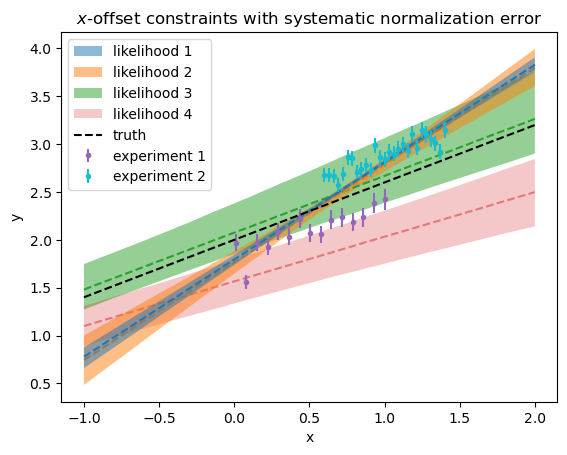

In [79]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    marker=".",
    linestyle="none",
    label="experiment 1",
    color="tab:purple",
    zorder=999,
)
plt.errorbar(
    x2,
    y_exp2,
    y_stat_err2,
    marker=".",
    linestyle="none",
    label="experiment 2",
    color="tab:cyan",
    zorder=999,
)
p = plt.fill_between(x_full, lower1, upper1, label="likelihood 1", alpha=0.5, zorder=99)
plt.plot(x_full, med1, "--", color=p.get_facecolor(), alpha=1, zorder=100)


p = plt.fill_between(x_full, lower2, upper2, label="likelihood 2", alpha=0.5, zorder=89)
plt.plot(x_full, med2, "--", color=p.get_facecolor(), alpha=1, zorder=90)


p = plt.fill_between(x_full, lower3, upper3, label="likelihood 3", alpha=0.5)
plt.plot(x_full, med3, "--", color=p.get_facecolor(), alpha=1, zorder=89)

p = plt.fill_between(x_full, lower4, upper4, label="likelihood 4", alpha=0.25)
plt.plot(x_full, med4, "--", color=p.get_facecolor(), alpha=0.5)


plt.plot(x_full, y_true_full, "k--", label="truth", zorder=999)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("$x$-offset constraints with systematic normalization error")